In [1]:
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

years = [str(year) for year in range(2000, 2020, 1)]
D = {}
for year in years:
  D[year] = pd.read_csv(f'./final data/{year}.dat', sep = '|', header = 0, index_col = 0)

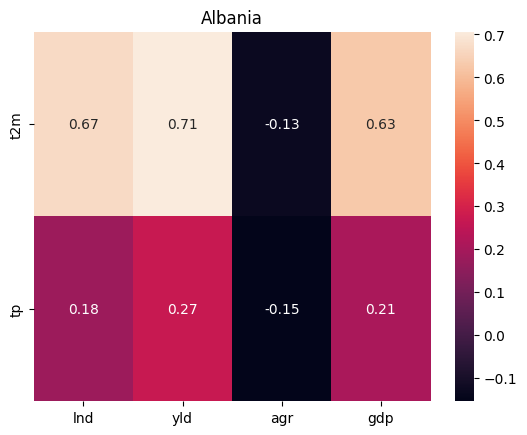

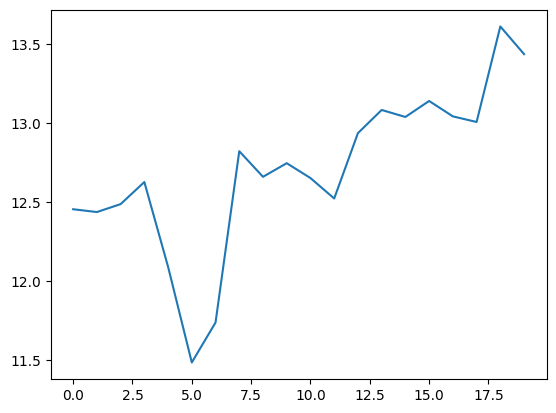

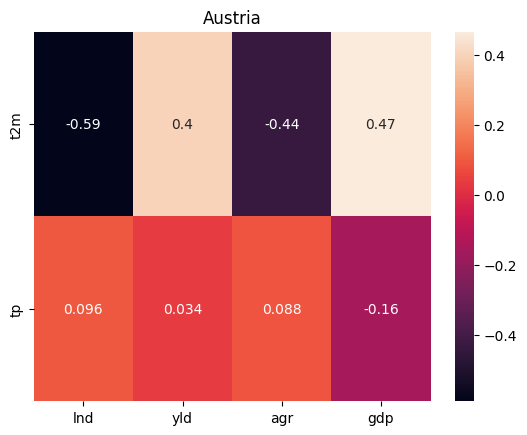

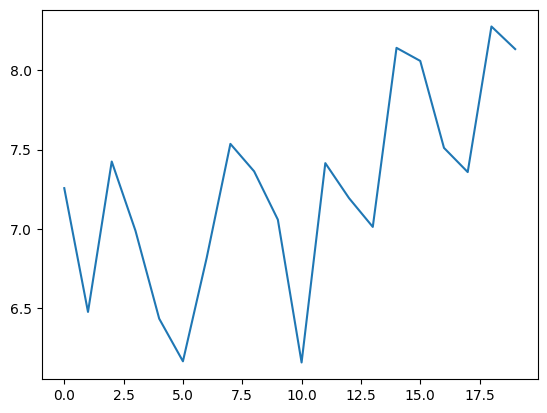

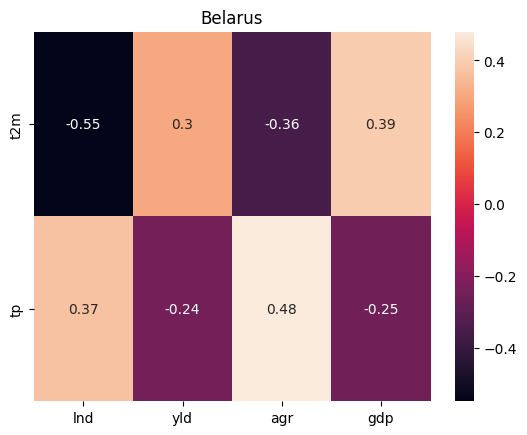

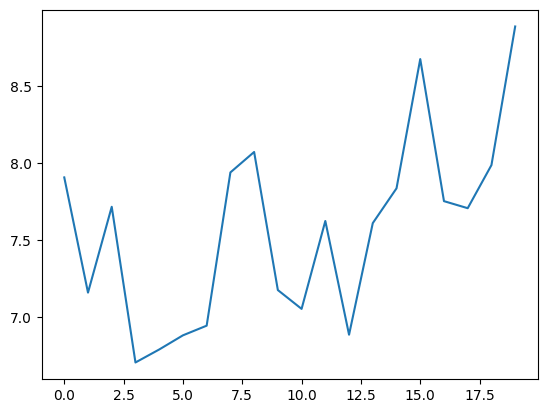

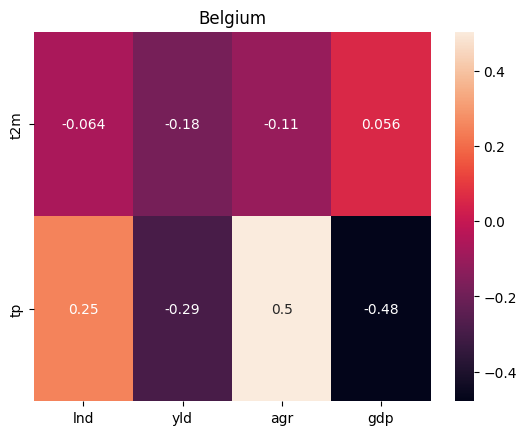

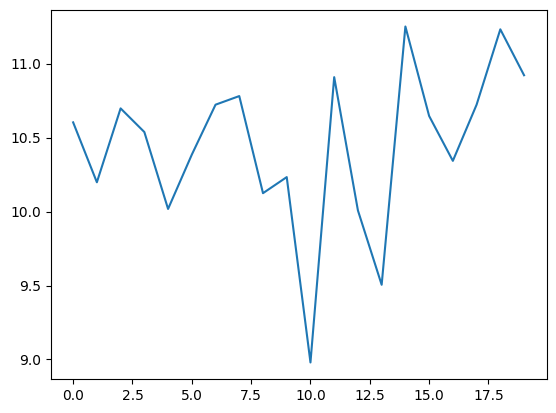

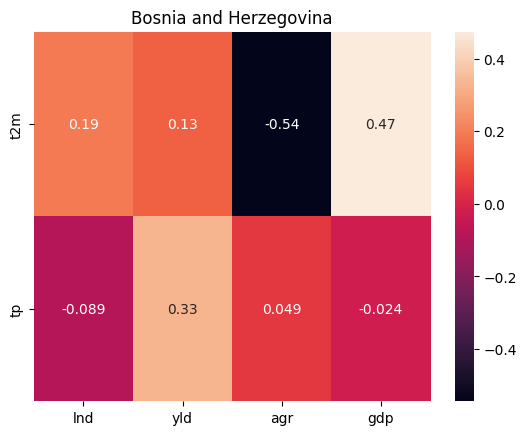

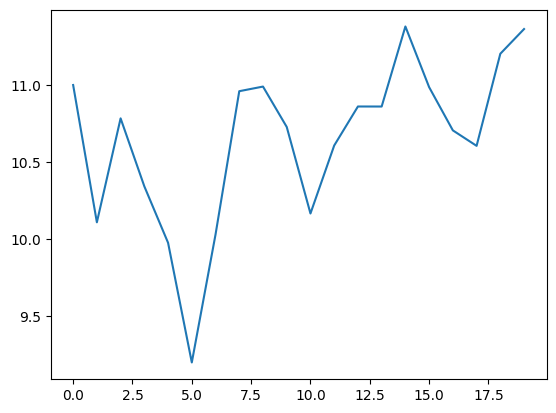

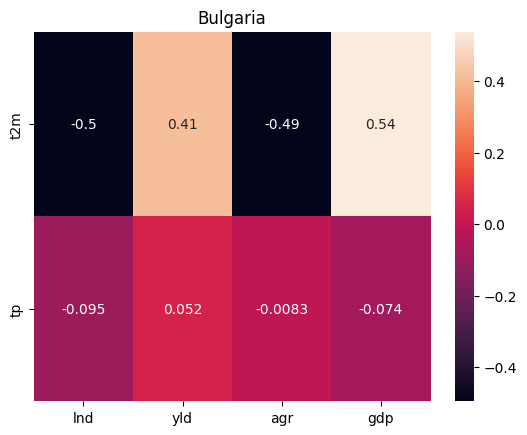

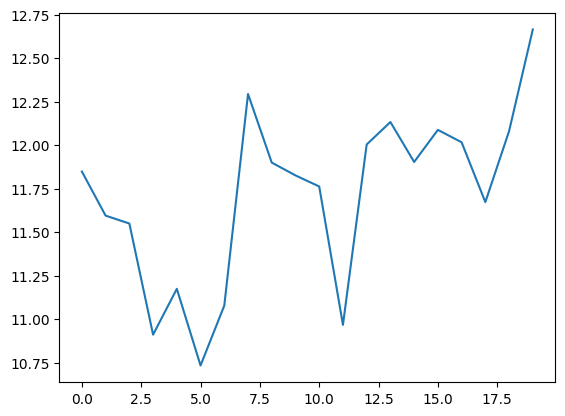

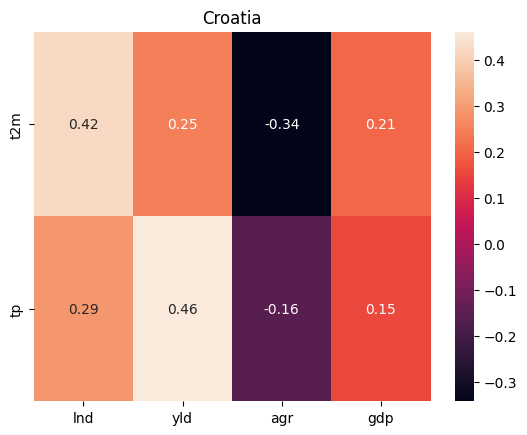

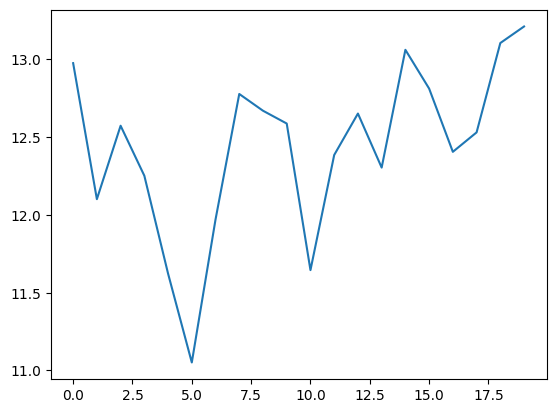

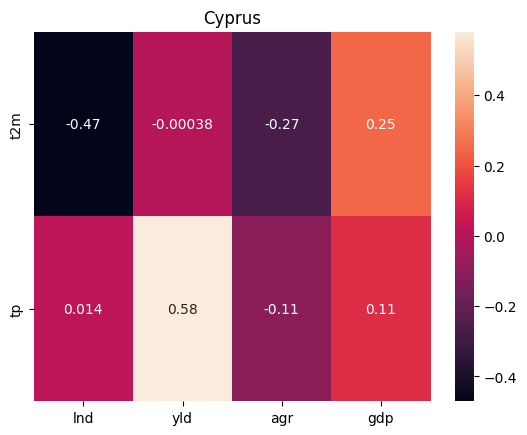

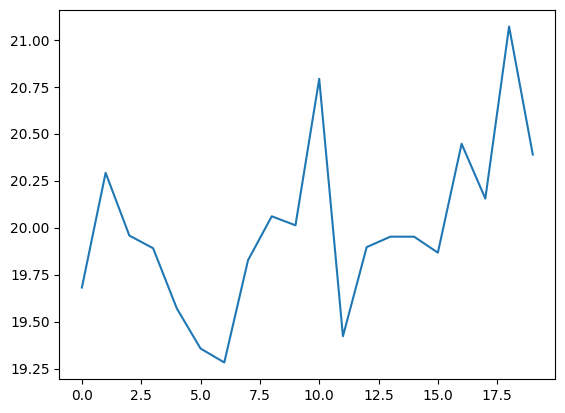

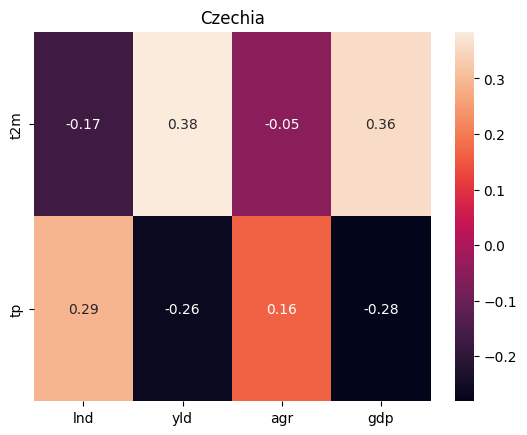

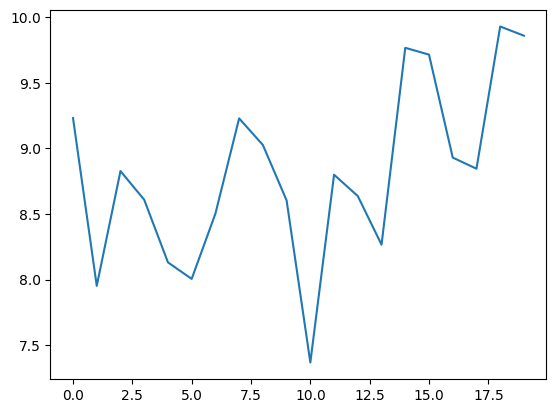

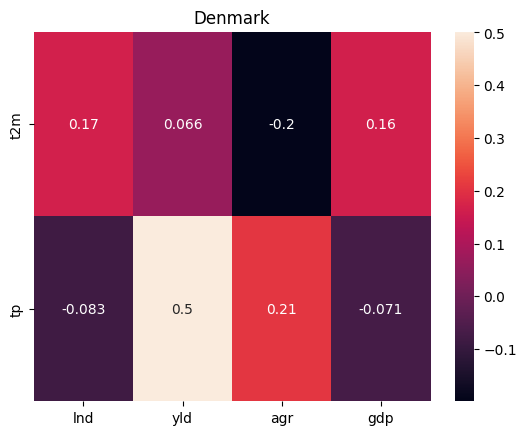

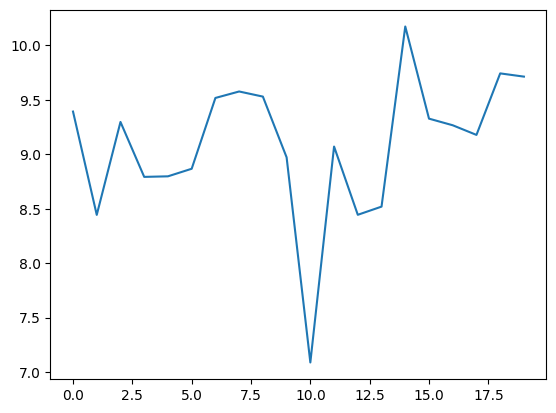

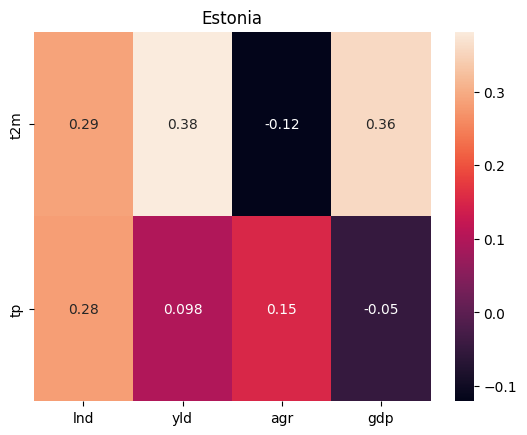

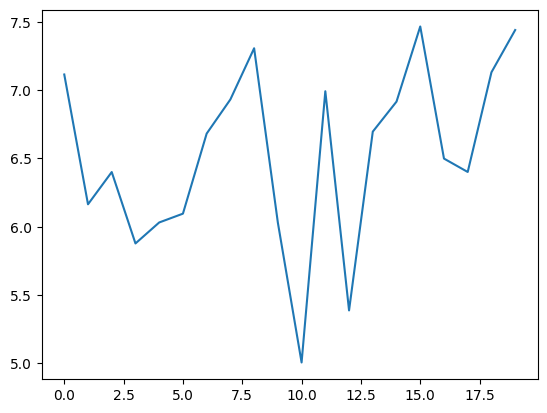

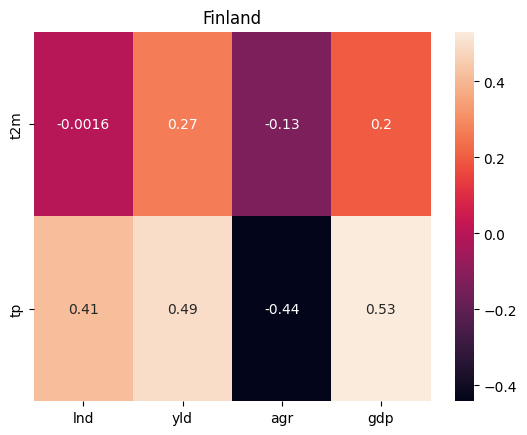

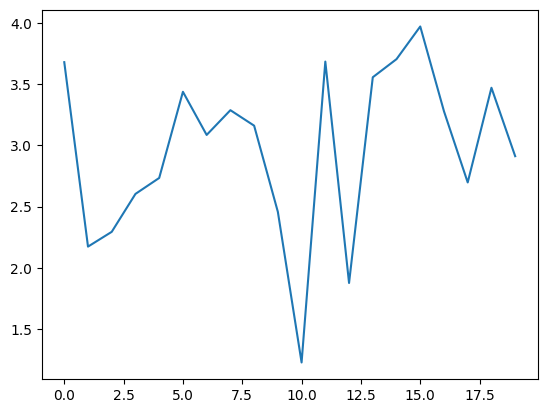

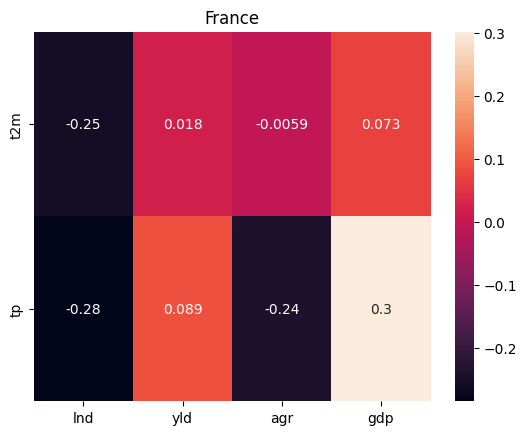

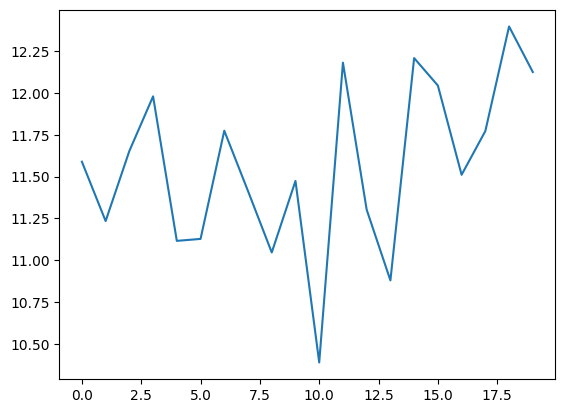

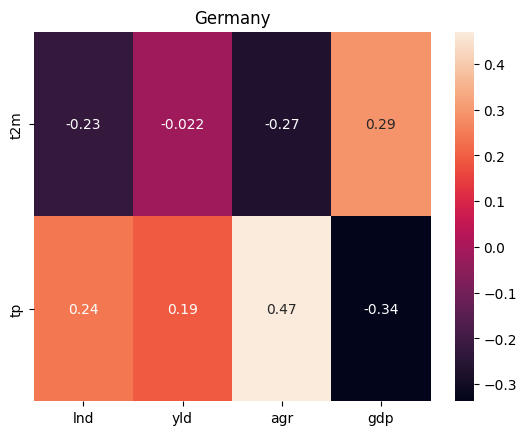

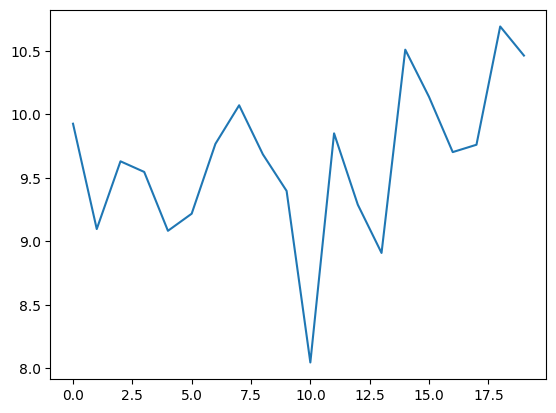

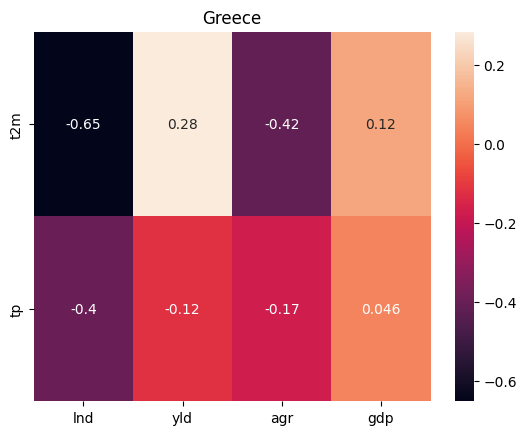

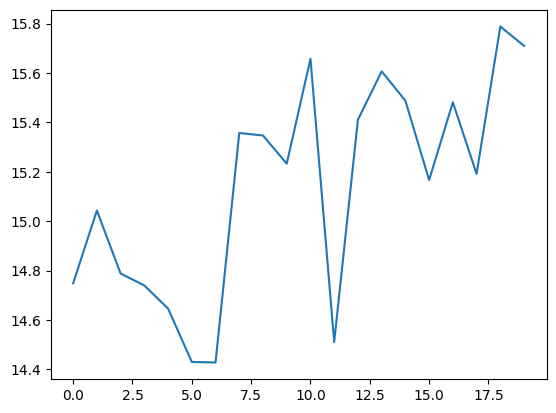

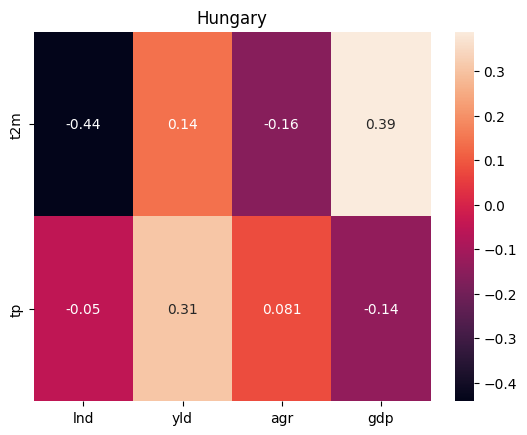

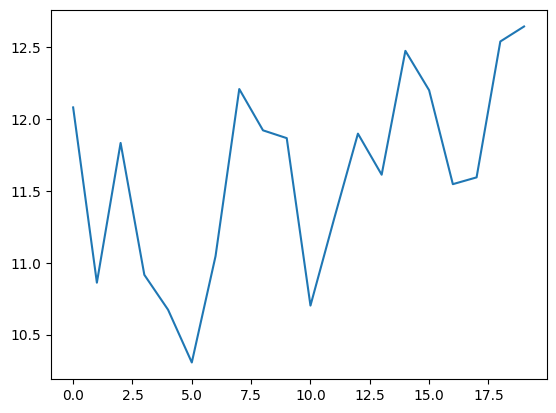

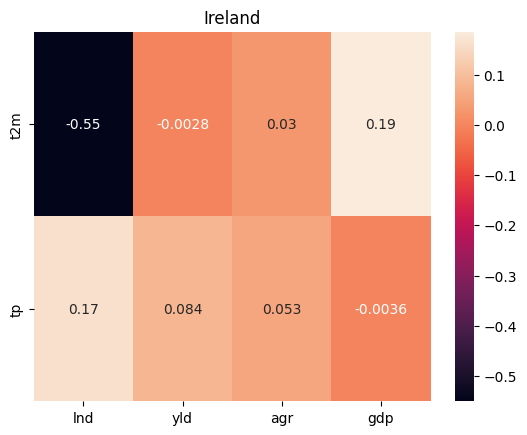

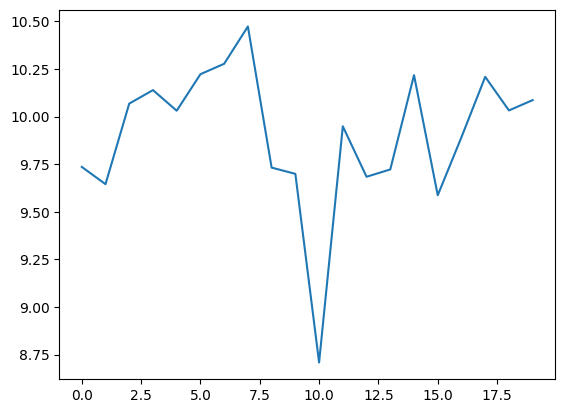

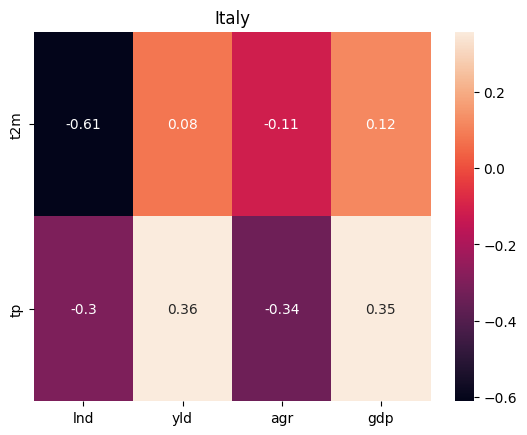

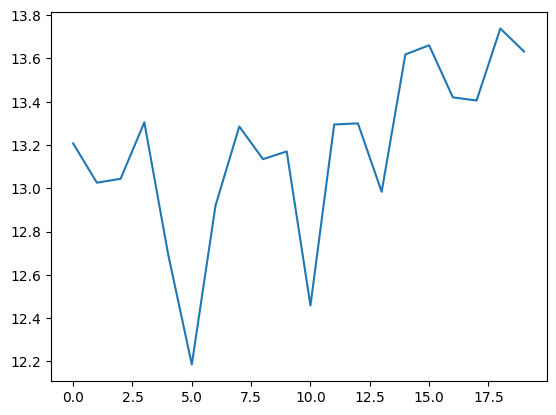

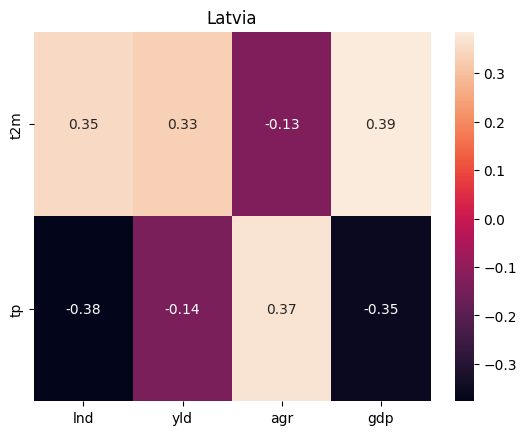

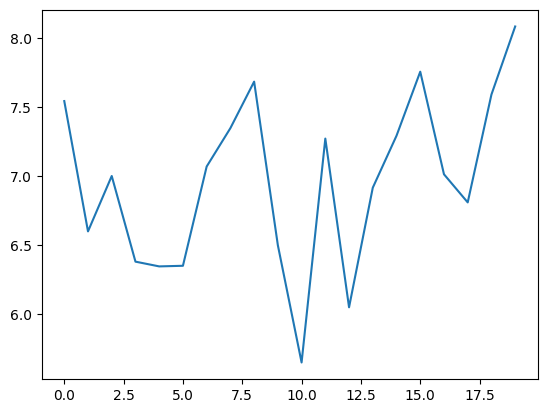

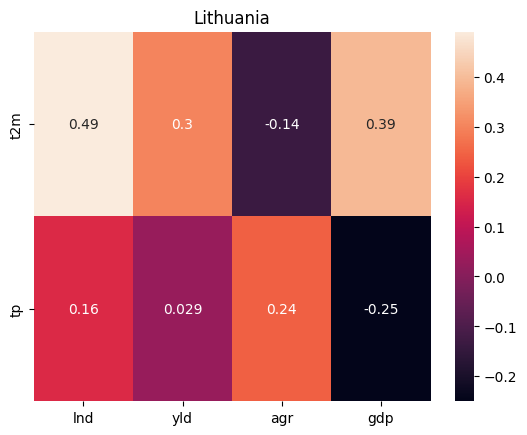

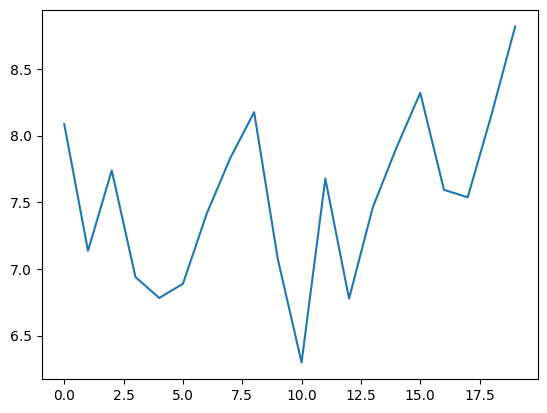

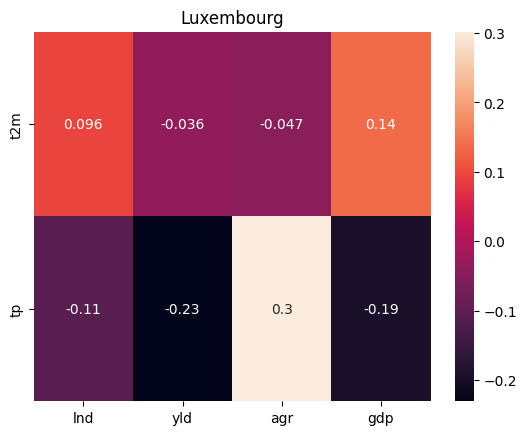

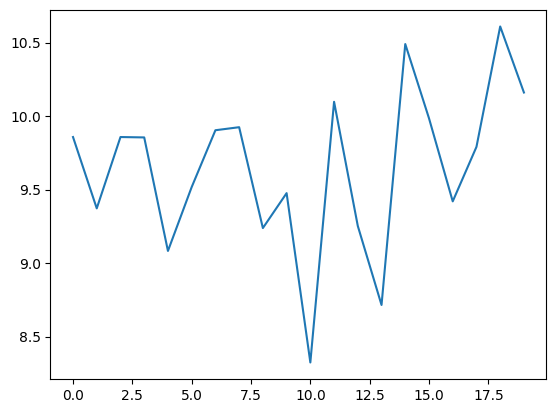

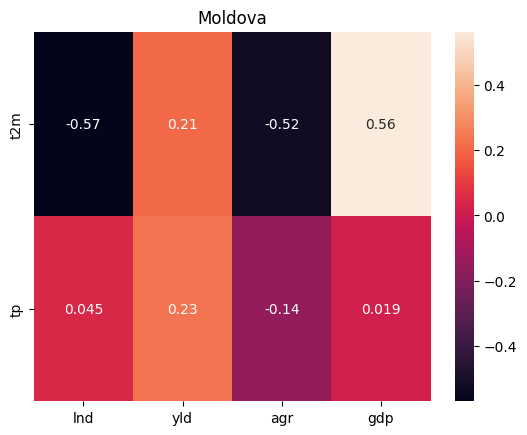

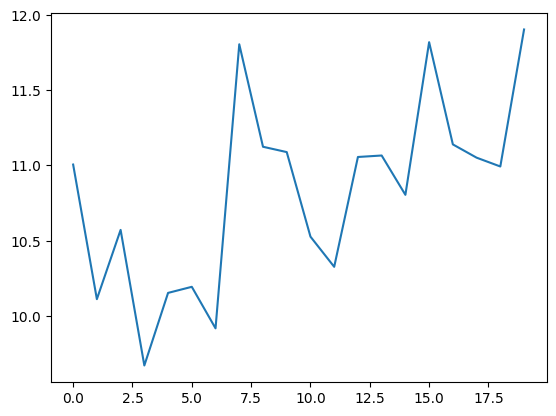

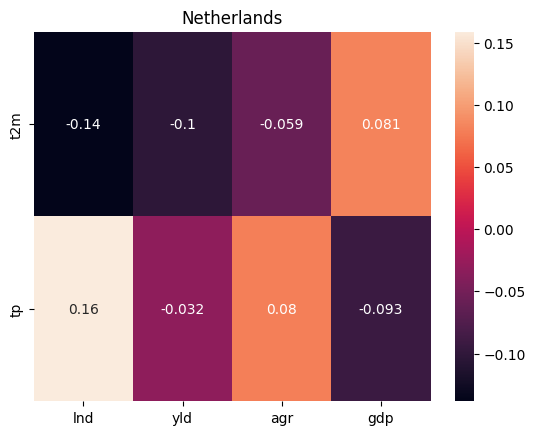

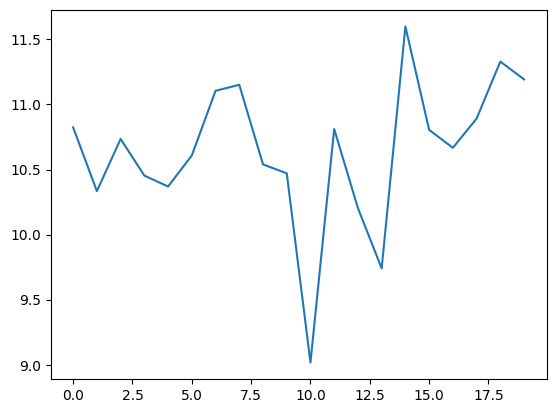

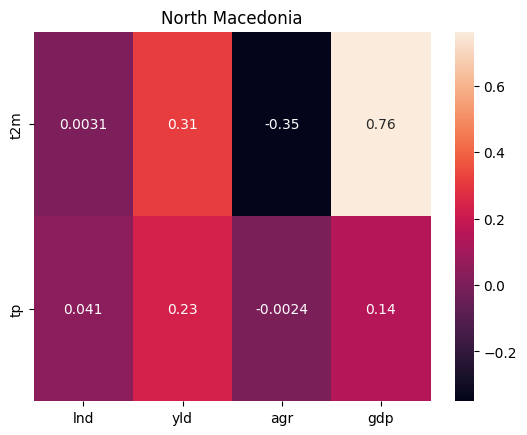

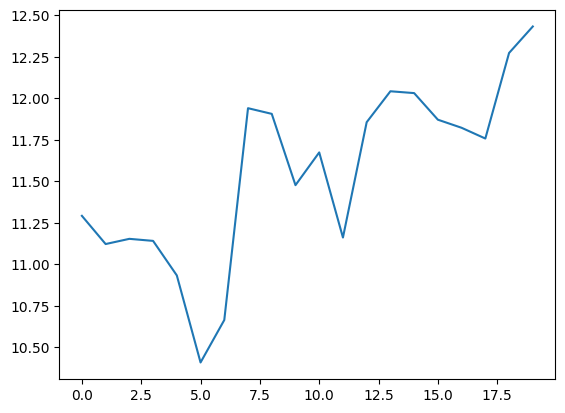

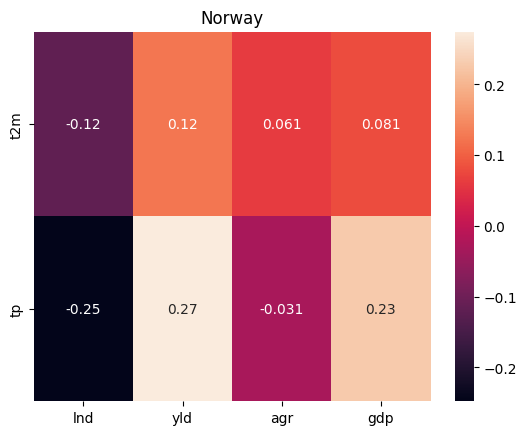

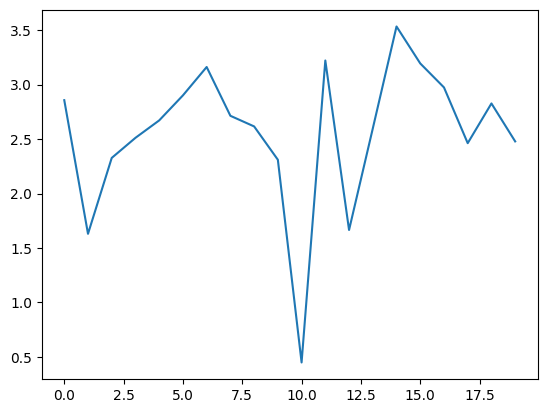

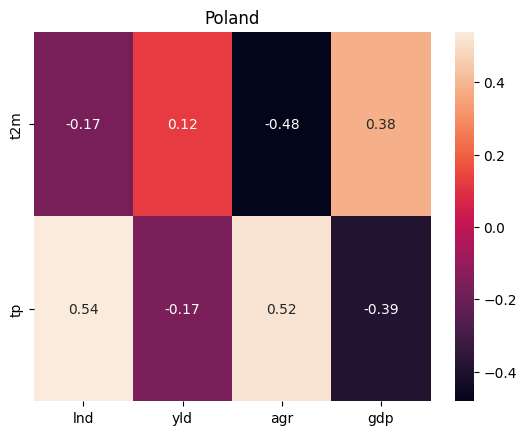

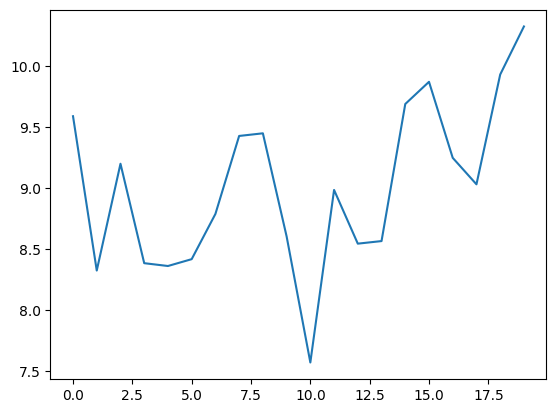

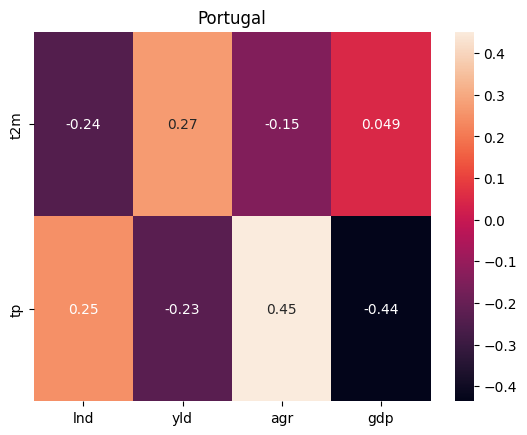

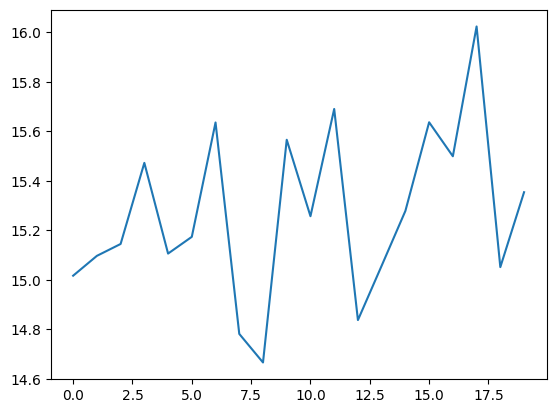

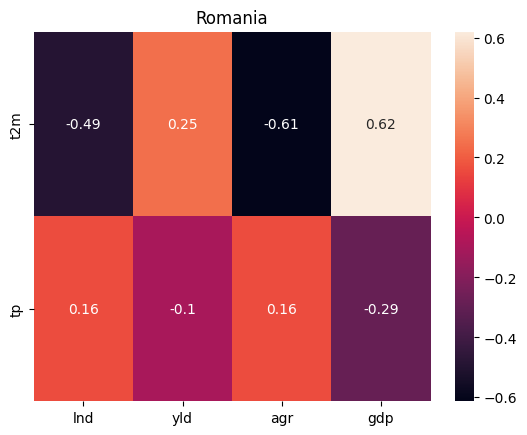

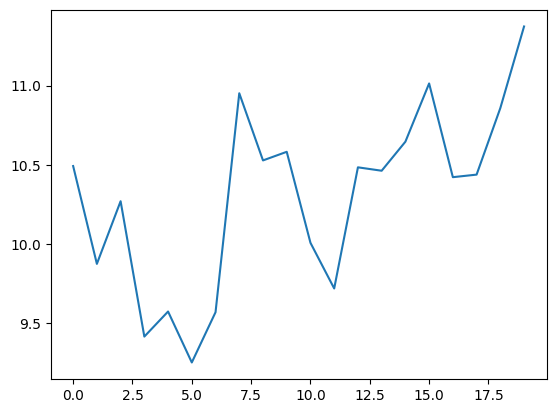

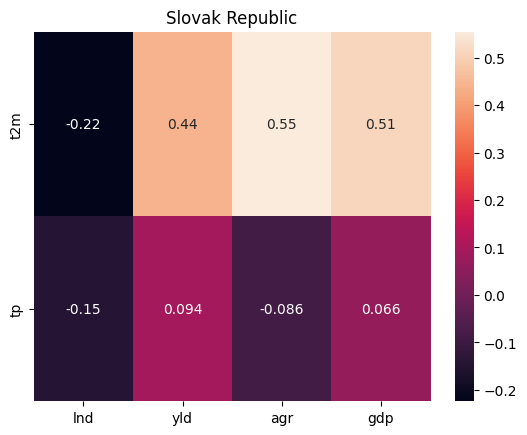

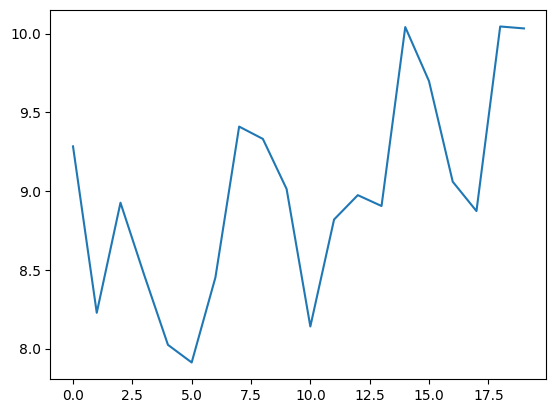

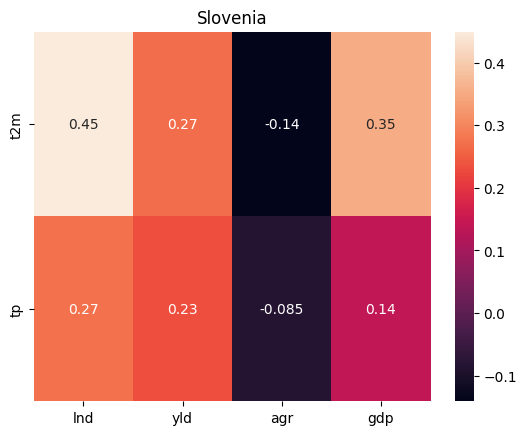

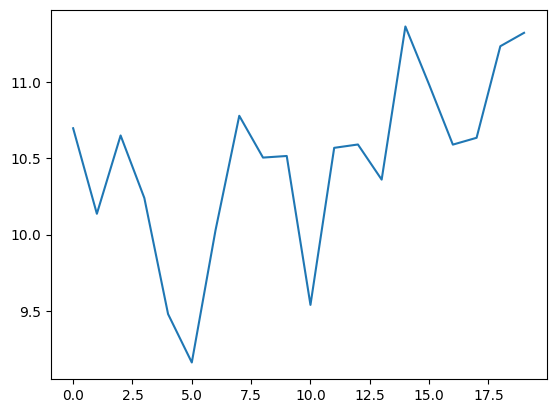

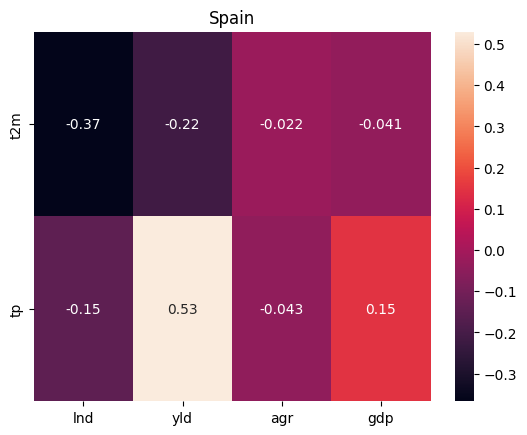

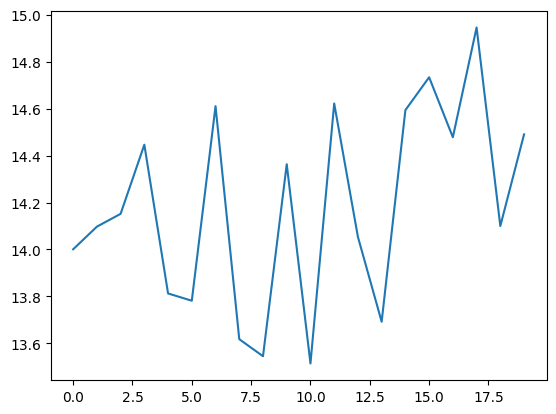

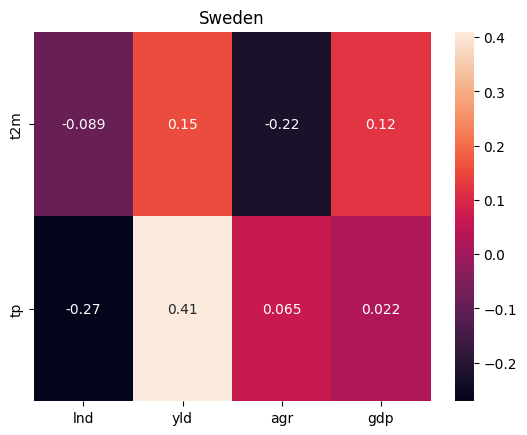

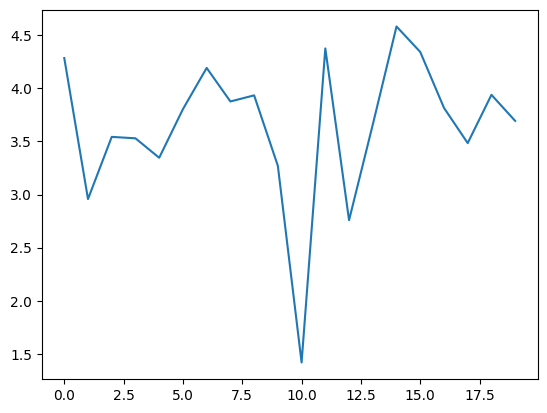

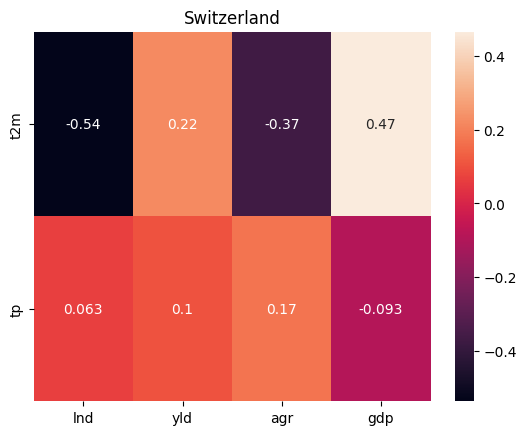

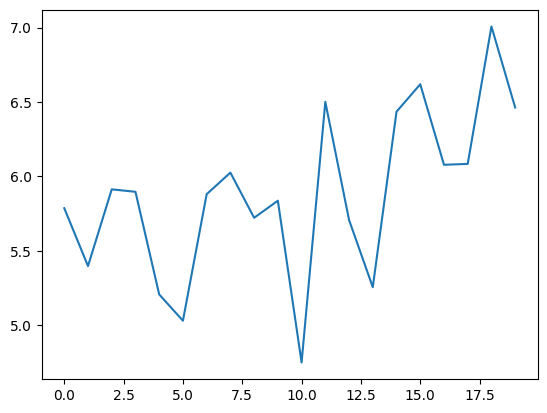

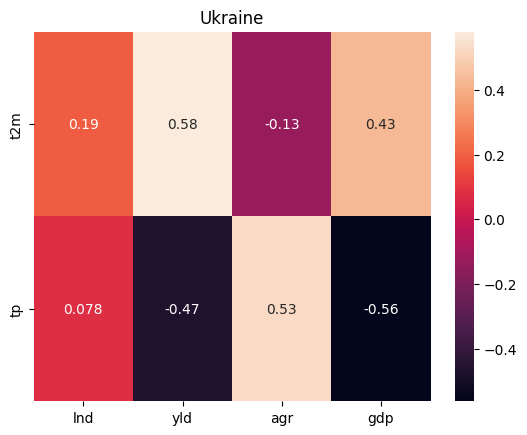

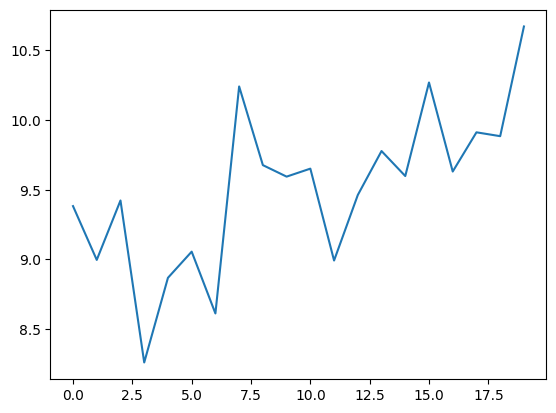

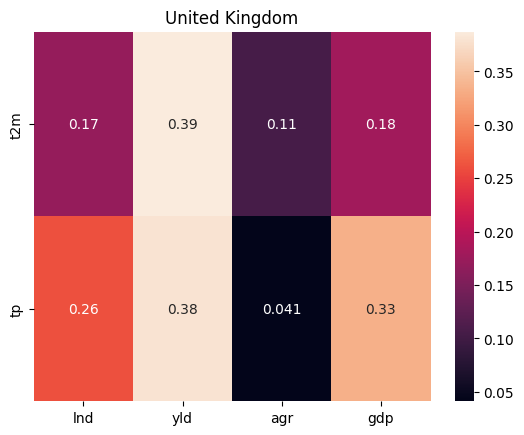

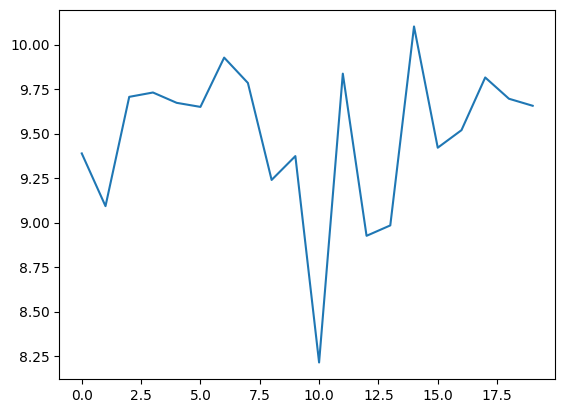

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

list_of_countries = D['2000']['country'].tolist()

summary = {}

T2Ms, TPs, LNDs, YLDs, AGRs, GDPs, = [], [], [], [], [], []
for country in list_of_countries:
    summary[country] = pd.DataFrame(columns=['t2m', 'tp', 'lnd', 'yld', 'agr', 'gdp'])
    for year in years:
        TPs.append(D[year][D[year]['country'] == country]['tp'].item())
        T2Ms.append(D[year][D[year]['country'] == country]['t2m'].item())
        LNDs.append(D[year][D[year]['country'] == country]['lnd'].item())
        YLDs.append(D[year][D[year]['country'] == country]['yld'].item())
        AGRs.append(D[year][D[year]['country'] == country]['agr'].item())
        GDPs.append(D[year][D[year]['country'] == country]['gdp'].item())
    summary[country]['t2m'] = T2Ms
    summary[country]['tp'] = TPs
    summary[country]['lnd'] = LNDs
    summary[country]['yld'] = YLDs
    summary[country]['agr'] = AGRs
    summary[country]['gdp'] = GDPs
    corr = summary[country].corr()
    corr = corr.loc[['t2m', 'tp'], ['lnd','yld','agr','gdp']]
    sns.heatmap(corr, annot = True)
    plt.title(country)
    plt.show()

    summary[country]['t2m'].plot()
    plt.show()
    T2Ms, TPs, LNDs, YLDs, AGRs, GDPs, = [], [], [], [], [], []

In [3]:
sum = pd.DataFrame(columns=['country', 't2m', 'tp', 'lnd', 'yld', 'agr', 'gdp'])
for i,country in enumerate(list_of_countries):
  sum.loc[i, 't2m':] = summary[country].mean()
  sum.loc[i, 'country'] = country
sum = sum.reset_index(drop = True)
for p in ['t2m', 'tp', 'lnd', 'yld', 'agr', 'gdp']:
  sum[p] = pd.to_numeric(sum[p])

# Clustering

In [4]:
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.cluster import KMeans

scaler = StandardScaler()
X = scaler.fit_transform(sum.loc[:, 't2m':])
kmeans = KMeans(n_clusters=3, random_state=21, n_init="auto").fit(X)

In [5]:
kmeans_preds = kmeans.fit_predict(X)
sum['kmeans'] = kmeans_preds

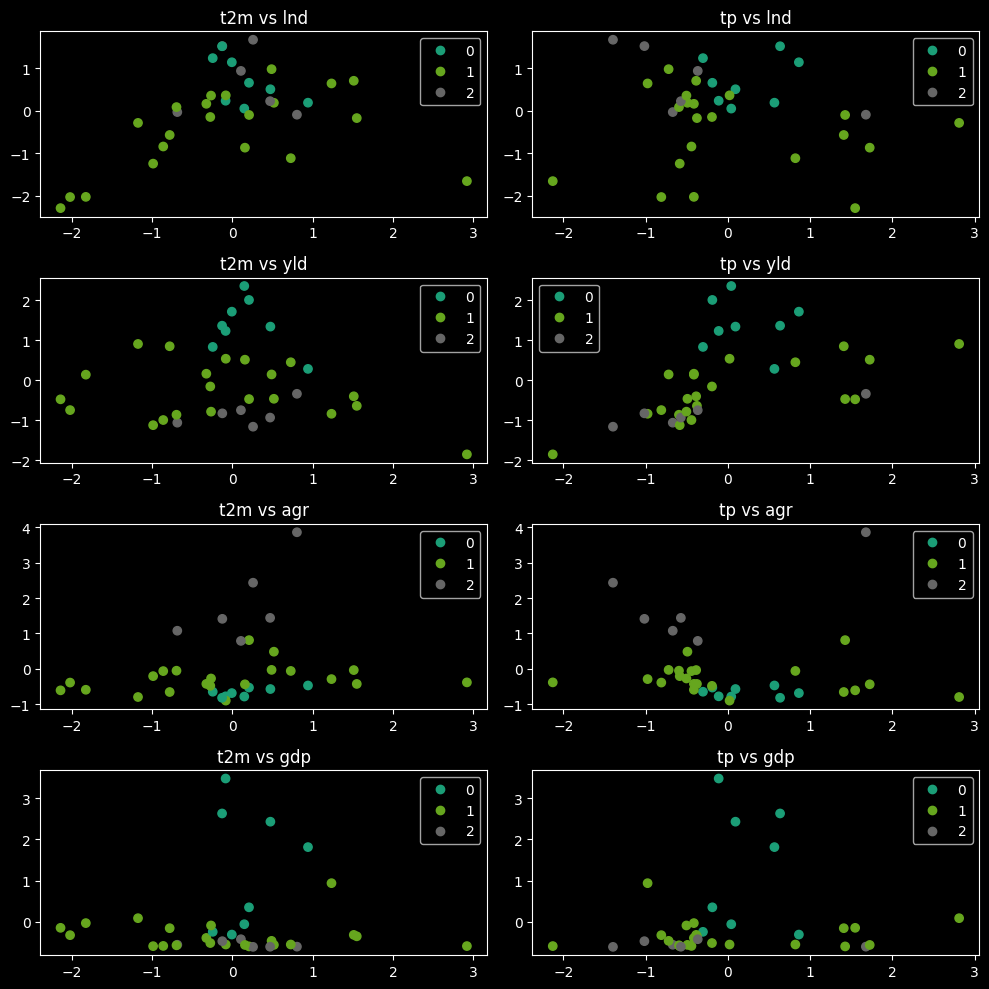

In [39]:
plt.style.use('dark_background')

cmap = plt.get_cmap('Dark2')
fig, axs = plt.subplots(4, 2, figsize=(10, 10))

for i, pred in enumerate(['t2m', 'tp']):
    for j, target in enumerate(['lnd', 'yld', 'agr', 'gdp']):
        # Select the data for the current variables
        current_data = X[:, [i, j + 2]]

        # Plot the scatter plot
        ax = axs[j, i]
        scatter = ax.scatter(current_data[:, 0], current_data[:, 1], c = kmeans_preds, cmap = cmap)

        # Set the subplot title
        ax.set_title(f'{pred} vs {target}')
        ax.legend(*scatter.legend_elements())
plt.tight_layout()
plt.savefig('kmeans_clustering.png')
plt.show()

In [6]:
countries = sum[sum['kmeans']==2]['country']
modeling_data = pd.DataFrame(columns=['t2m', 'tp', 'lnd', 'yld', 'agr', 'gdp', 'kmeans'])
for i,country in enumerate(sum['country'].tolist()):
    summary[country]['kmeans'] = [sum[sum['country']==country]['kmeans'].item()]*len(summary[country])
    modeling_data = pd.concat([modeling_data, summary[country]], axis = 0)
# for i,country in enumerate(countries):
#   modeling_data = pd.concat([modeling_data, summary[country]], axis = 0)

one_hot = pd.get_dummies(modeling_data['kmeans'].reset_index(drop=True))
one_hot = one_hot.rename(columns={0: 'Cluster 1', 1: 'Cluster 2', 2: 'Cluster 3'})
modeling_data = modeling_data.drop('kmeans',axis = 1)
modeling_data = modeling_data.drop('lnd',axis = 1)
modeling_data = modeling_data.join(one_hot)
modeling_data = modeling_data.reset_index(drop = True)

# Modeling

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
X_train, X_test, y_train, y_test = train_test_split(modeling_data.loc[:, ~modeling_data.columns.isin(['gdp'])],
                                                    modeling_data.loc[:, [ 'gdp']], test_size = 0.25, 
                                                    random_state = 21, shuffle = True)

X_train_no_meteo, X_test_no_meteo, y_train_no_meteo, y_test_no_meteo = train_test_split(modeling_data.loc[:,
                                                        ~modeling_data.columns.isin(['gdp', 't2m', 'tp'])],
                                                    modeling_data.loc[:, [ 'gdp']], test_size = 0.25, 
                                                                                        random_state = 21, shuffle = True)


In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

n = 350

rf = RandomForestRegressor(n_estimators = n, criterion = 'squared_error', max_depth = None, min_samples_split=2,
                            n_jobs = -1,
                           random_state = 42)
rf_no_meteo = RandomForestRegressor(n_estimators = n, criterion = 'squared_error', max_depth = None, min_samples_split=2,
                            n_jobs = -1,
                           random_state = 42)
rf.fit(X_train, y_train)
rf_no_meteo.fit(X_train_no_meteo, y_train_no_meteo)

predictions = rf.predict(X_test)
preds = pd.DataFrame({ "gdp":predictions})

predictions = rf_no_meteo.predict(X_test_no_meteo)
preds_no_meteo = pd.DataFrame({ "gdp":predictions})


test_score = r2_score(y_test, preds)
train_score = r2_score(y_train, rf.predict(X_train))

test_score_no_meteo = r2_score(y_test_no_meteo, preds_no_meteo)
train_score_no_meteo = r2_score(y_train_no_meteo, rf_no_meteo.predict(X_train_no_meteo))
print('     Random Forest')
print(' ------METEO+AGR-----\n','Test score', np.round(test_score,3), '\n',
      'Train score:', np.round(train_score,3), '\n','--------------------\n')
print(' ------NO METEO------\n','Test score', np.round(test_score_no_meteo,3), '\n',
      'Train score:', np.round(train_score_no_meteo,3), '\n','--------------------\n')

     Random Forest
 ------METEO+AGR-----
 Test score 0.789 
 Train score: 0.951 
 --------------------

 ------NO METEO------
 Test score 0.567 
 Train score: 0.907 
 --------------------



In [10]:
from xgboost import XGBRegressor
import numpy as np

n = 500
m = 20
model = XGBRegressor(eta = 0.01,gamma=0.01,
                    max_depth = m, n_jobs = -1,
                    n_estimators = n, subsample=0.85, colsample_bytree=1,
                    objective = 'reg:squarederror', reg_lambda = 1, reg_alpha = 1,
                    random_state = 42)
model_no_meteo = XGBRegressor(eta = 0.01,gamma=0.01,
                    max_depth = m, n_jobs = -1,
                    n_estimators = n, subsample=0.85, colsample_bytree=1,
                    objective = 'reg:squarederror', reg_lambda = 1, reg_alpha = 1,
                    random_state = 42)
model.fit(X_train, y_train)
model_no_meteo.fit(X_train_no_meteo, y_train_no_meteo)

predictions = model.predict(X_test)
preds = pd.DataFrame({"gdp":predictions})

predictions_no_meteo = model_no_meteo.predict(X_test_no_meteo)
preds_no_meteo = pd.DataFrame({"gdp":predictions_no_meteo})

test_score = r2_score(y_test, preds)
train_score = r2_score(y_train, model.predict(X_train))

test_score_no_meteo = r2_score(y_test_no_meteo, preds_no_meteo)
train_score_no_meteo = r2_score(y_train_no_meteo, model_no_meteo.predict(X_train_no_meteo))
print('\tXGBoost')
print(' ------METEO+AGR-----\n','Test score', np.round(test_score,3), '\n',
      'Train score:', np.round(train_score,3), '\n','--------------------\n')
print(' ------NO METEO------\n','Test score', np.round(test_score_no_meteo,3), '\n',
      'Train score:', np.round(train_score_no_meteo,3), '\n','--------------------\n')

	XGBoost
 ------METEO+AGR-----
 Test score 0.802 
 Train score: 0.998 
 --------------------

 ------NO METEO------
 Test score 0.568 
 Train score: 0.994 
 --------------------



# Monte-Carlo

In [34]:
modeling_data[]

t2m            14.100175
tp              0.000130
yld          3175.100000
agr            24.515412
Cluster 1       0.000000
Cluster 2       0.000000
Cluster 3       1.000000
Name: 0, dtype: float64

In [35]:
rf.predict(row.to_numpy().reshape(1,-1))

array([5.19744289e+11])

In [69]:
import math
from scipy.stats import norm, truncnorm
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as MSE

def RE(mod, true):
    return ((mod-true)/true)


RE_t2m, RE_tp, MSE_t2m, MSE_tp, MAPE_t2m, MAPE_tp= [], [],[], [], [], []
summary_t2m, summary_tp, summary_mse_t2m, summary_mse_tp, summary_mape_t2m, summary_mape_tp = [], [],[], [], [], []
STDs = [0.01, 0.05, 0.1, 0.2, 0.25, 0.5]
variables = ['t2m', 'tp']

REs, MSEs, MAPEs = {}, {}, {}

for std in STDs:
    for i in range(len(modeling_data)):
        row, row_t2m, row_tp = modeling_data.loc[i, ~modeling_data.columns.isin(['gdp'])],\
                               modeling_data.loc[i, ~modeling_data.columns.isin(['gdp'])],\
                               modeling_data.loc[i, ~modeling_data.columns.isin(['gdp'])]
        true = model.predict(row.to_numpy().reshape(1,-1))
        for _ in range(10):
            sample_t2m = norm.rvs(loc=row['t2m'], scale=abs(row['t2m'])*std, size=1)
            sample_tp = truncnorm.rvs(0, np.inf, loc=row['tp'], scale=abs(row['tp'])*std, size=1)
            row_t2m['t2m'] = sample_t2m
            row_tp['tp'] = sample_tp
            pred_t2m = model.predict(row_t2m.to_numpy().reshape(1,-1))
            pred_tp = model.predict(row_tp.to_numpy().reshape(1,-1))
            RE_t2m.append(RE(pred_t2m, true)[0])
            RE_tp.append(RE(pred_tp, true)[0])
            MSE_t2m.append(MSE(true, pred_t2m))
            MSE_tp.append(MSE(true, pred_tp))
            MAPE_t2m.append(MAPE(true, pred_t2m))
            MAPE_tp.append(MAPE(true, pred_tp))
    summary_t2m.append(np.array(RE_t2m)) 
    summary_tp.append(np.array(RE_tp)) 
    summary_mse_t2m.append(np.array(MSE_t2m)) 
    summary_mse_tp.append(np.array(MSE_tp))
    summary_mape_t2m.append(np.array(MAPE_t2m)) 
    summary_mape_tp.append(np.array(MAPE_tp))
    RE_t2m, RE_tp, MSE_t2m, MSE_tp, MAPE_t2m, MAPE_tp= [], [],[], [], [], []
    print(f'STD: {std} is done!')
REs['t2m'], REs['tp'] = summary_t2m, summary_tp
MSEs['t2m'], MSEs['tp'] = summary_mse_t2m, summary_mse_tp
MAPEs['t2m'], MAPEs['tp'] = summary_mape_t2m, summary_mape_tp

STD: 0.01 is done!
STD: 0.05 is done!
STD: 0.1 is done!
STD: 0.2 is done!
STD: 0.25 is done!
STD: 0.5 is done!


In [70]:
for key in REs.keys():
    np.savetxt(f'./Monte-Carlo/{key}_re.dat', REs[key], delimiter='|') 
    np.savetxt(f'./Monte-Carlo/{key}_mse.dat', MSEs[key], delimiter='|')
    np.savetxt(f'./Monte-Carlo/{key}_mape.dat', MAPEs[key], delimiter='|')

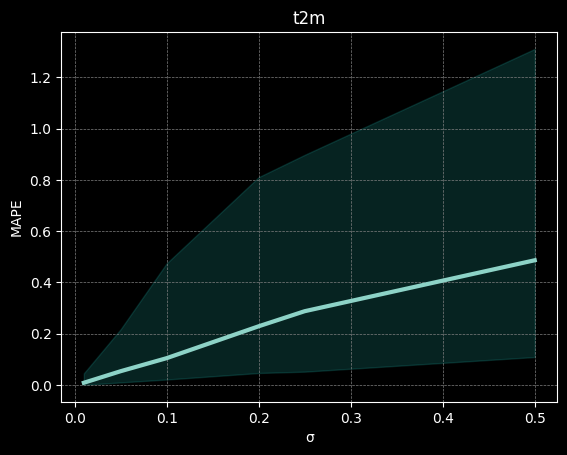

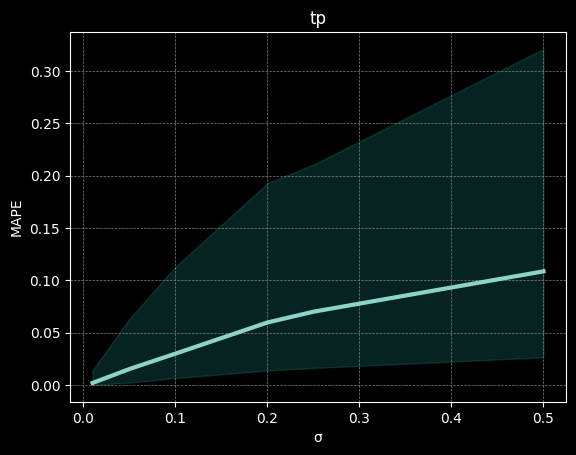

In [78]:
from sklearn.preprocessing import Normalizer
V = {}
for var in ['t2m', 'tp']:
    V[var] = np.loadtxt(f'./Monte-Carlo/{var}_mape.dat',  delimiter='|') 
    #V[var] = Normalizer().fit_transform(V[var])
    #V[var] = (V[var] - np.min(V[var])) / (np.max(V[var]) - np.min(V[var]))
    
    medians = np.median(V[var], axis = 1)
    #print(medians)
    q1, q3 = np.percentile(V[var], [25, 75], axis=1)
    iqr = q3 - q1
    plt.plot(STDs, medians, linewidth=3)
    
    plt.fill_between(x = STDs, y1 = q1, y2 = q3, alpha=0.2, color='lightseagreen')

    plt.title(var)
    #plt.ylim(-1, 1)
    #plt.xlim(0, 0.5)
    plt.xlabel('σ')
    plt.ylabel('MAPE')
    plt.grid(True)
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.savefig(f'./{var}_mape')
    plt.show()

# Maps

In [109]:
sum

,country,t2m,tp,lnd,yld,agr,gdp,kmeans
0,Albania,12.699524,0.000151,42.350095,4193.000,19.454357,1.035328e+10,2
1,Austria,7.238918,0.000143,33.746552,6207.960,1.321203,3.624556e+11,1
2,Belarus,7.565957,0.000084,43.459142,2968.880,8.276265,4.635435e+10,2
3,Belgium,10.440843,0.000104,44.939271,8761.645,0.806515,4.381538e+11,0
4,Bosnia and Herzegovina,10.645236,0.000143,42.235742,3969.700,7.210355,1.473611e+10,1
5,Bulgaria,11.711118,0.000089,47.382252,3981.675,5.897456,4.405450e+10,1
6,Croatia,12.434930,0.000126,23.917055,5530.080,3.713284,5.116818e+10,1
7,Cyprus,19.993380,0.000042,14.209852,1626.365,2.414793,2.105298e+10,1
8,Czechia,8.812033,0.000091,46.955753,5044.225,2.244488,1.766298e+11,1
9,Denmark,9.086251,0.000094,66.304244,6179.990,1.352609,2.929704e+11,0


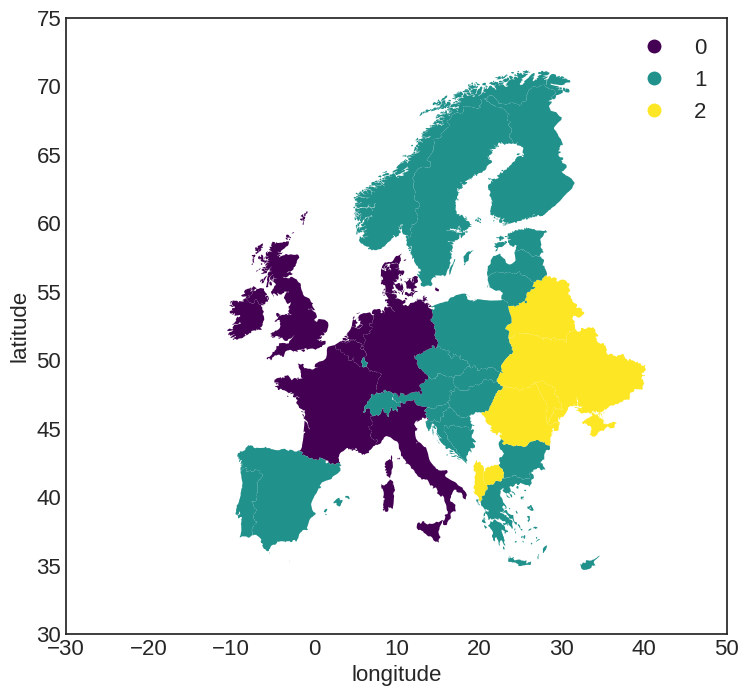

In [183]:
import xarray as xr
import geopandas as gpd
import regionmask
plt.rcParams.update({'font.size': 16, 'figure.figsize': (16, 9)})
plt.style.use('seaborn-white')

boundaries = gpd.read_file('./World_Countries_(Generalized)/World_Countries__Generalized_.shp')
boundaries['COUNTRY'] = boundaries['COUNTRY'].replace({'Czech Republic': 'Czechia'})
boundaries['COUNTRY'] = boundaries['COUNTRY'].replace({'Slovakia': 'Slovak Republic'})
boundaries = boundaries[boundaries['COUNTRY'].isin(sum['country'].tolist())].reset_index()
boundaries = boundaries.join(sum['kmeans'].astype('int64'))

countries_mask_poly = regionmask.Regions(
    name='COUNTRY',
    numbers=boundaries.index,
    names=boundaries.COUNTRY,
    abbrevs=boundaries.ISO,
    outlines=list(boundaries.geometry.values[i] for i in range(0, boundaries.shape[0]))
)

cmap = plt.get_cmap('viridis')
plt.figure(figsize=(16,8))
ax = plt.axes()
boundaries.plot(ax = ax, column = 'kmeans',  categorical = True,
                cmap = cmap, legend = True)
plt.xlim(-30,50)
plt.ylim(30, 75)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.savefig('cluster_map.png', transparent = True)
plt.show()